In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# Based on tf xfer learning tutorial at https://www.tensorflow.org/tutorials/images/transfer_learning
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
## change below path to /tf/username/model_img/ALL
PATH = '/tf/visibility/model_img/0701-4cl/' #GFAL
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

#set batch size and original image dimensions
batch_size = 90 #TODO figure out what the OOM issue is
img_height = 720
img_width = 1280

#total image count
print(image_count)

51463


(720, 1280, 3)


array([[[47, 52, 56],
        [42, 47, 51],
        [39, 44, 48],
        [43, 48, 52]],

       [[39, 44, 48],
        [35, 40, 44],
        [33, 38, 42],
        [37, 42, 46]],

       [[35, 40, 44],
        [33, 38, 42],
        [32, 37, 41],
        [35, 40, 44]],

       [[34, 39, 43],
        [35, 40, 44],
        [37, 42, 46],
        [40, 45, 49]]], dtype=uint8)

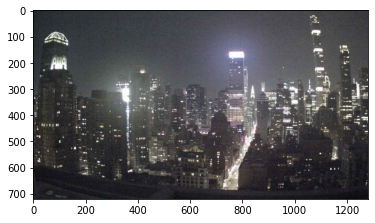

In [5]:
#do a quick check and make sure you have image data
files = os.listdir(f'{PATH}/excellent')[:10]
img = plt.imread(f'{PATH}/excellent/{files[9]}')
plt.imshow(img);
print(img.shape)
# First 4 rows and columns of the image
img[:4,:4]

In [6]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label != '.ipynb_checkpoints': #not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [ ]:
#run rm -rf .ipynb_checkpoints to get correct class names
%cd /tf/visibility/model_img/0701-4cl/
%rm -rf .ipynb_checkpoints

In [7]:
def prep_fn(img):
    """
    Convert pixel values from [0, 255] to [-1, 1]
    """
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

In [8]:
#set up generators for training and validation data

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    zoom_range=0.1,
    preprocessing_function=prep_fn)
#train_datagen.fit(np.stack(list(train_ds)))
val_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn, validation_split=0.2)

gen_kwargs = dict(seed=123, batch_size=batch_size, class_mode='sparse', target_size=(img_height, img_width))
train_gen = train_datagen.flow_from_directory(
    data_dir,
    subset="training",
    **gen_kwargs
    )
val_gen = val_datagen.flow_from_directory(
    data_dir,
    subset="validation",
    **gen_kwargs)

Found 41172 images belonging to 4 classes.
Found 10291 images belonging to 4 classes.


In [9]:
#comment out if doing cropping
#del(train_ds.class_names[0])
#del(val_ds.class_names[0])
class_names = [key for key in train_gen.class_indices]
print(class_names)

['excellent', 'fair', 'poor', 'reduced']


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


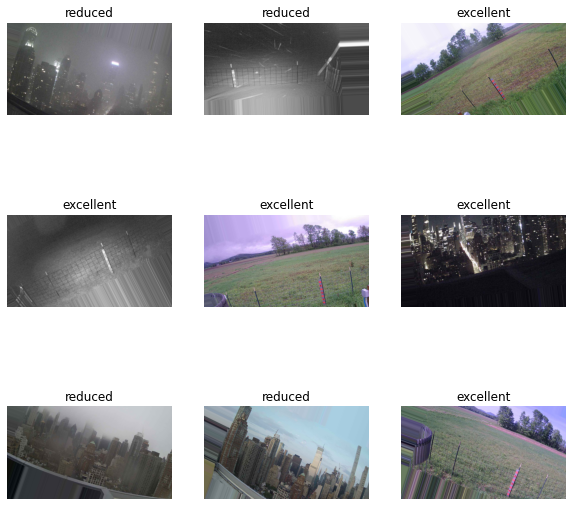

In [10]:
#display a few images for a sanity check (all labels should be correct, and no imgs should be corrupted)
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_gen))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] + 1) / 2)
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = images.shape[1:]
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_gen)) #batch size of 128 is too large for memory. Is there any way to get image_batch from the datagens? W/o using datagen.fit()?
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(90, 23, 40, 1280)


**Lock pretrained model weights so they aren't thrown off by the untrained classification layers:**

In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 1280, 3 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 360, 640, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 360, 640, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 360, 640, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
#classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(90, 1280)


In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
for i in range(1, 3):
    x = tf.keras.layers.Dense(x.shape[1] + len(class_names) - x.shape[1] / 3 * i, activation = 'elu')(x) #TODO different activ func (ELU?)
outputs = tf.keras.layers.Dense(len(class_names), activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #Sparse vs Categorical is e.g. [0, 0, 1, 0] instead of 2
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 720, 1280, 3)]    0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 23, 40, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 857)               1097817   
_________________________________________________________________
dense_1 (Dense)              (None, 289)               247962    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1160  

In [18]:
class_wgt = {2: 16, 3: 8, 1: 8, 0: 1}
train_kwargs = dict(validation_data=val_gen, class_weight=class_wgt, steps_per_epoch = 5, validation_steps=5)
epochs = 1
history = model.fit(
  train_gen,
  epochs=epochs,
  **train_kwargs
)

5/5 [==============================] - 196s 40s/step - loss: 5.6736 - accuracy: 0.2229 - val_loss: 1.2188 - val_accuracy: 0.4933


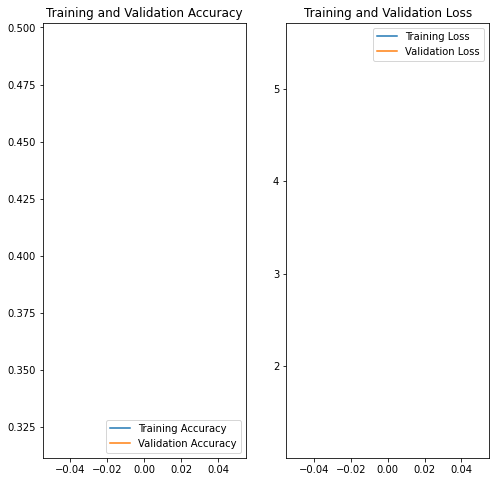

In [19]:
total_epochs = epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#additional epochs
epochs = 5
addl_history = model.fit(
  train_gen,
  epochs=epochs,
  **train_kwargs
)
total_epochs += epochs

Epoch 1/5
5/5 [==============================] - 192s 40s/step - loss: 3.6259 - accuracy: 0.4978 - val_loss: 1.3578 - val_accuracy: 0.4156
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 4.0305 - accuracy: 0.3511 

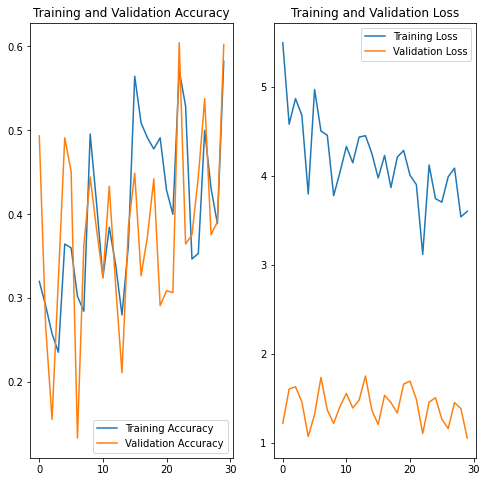

In [24]:
acc += addl_history.history['accuracy']
val_acc += addl_history.history['val_accuracy']

loss += addl_history.history['loss']
val_loss += addl_history.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.40458414 0.21404481 0.1917599  0.18961117]]
This image most likely belongs to excellent with a 40.46 percent confidence.


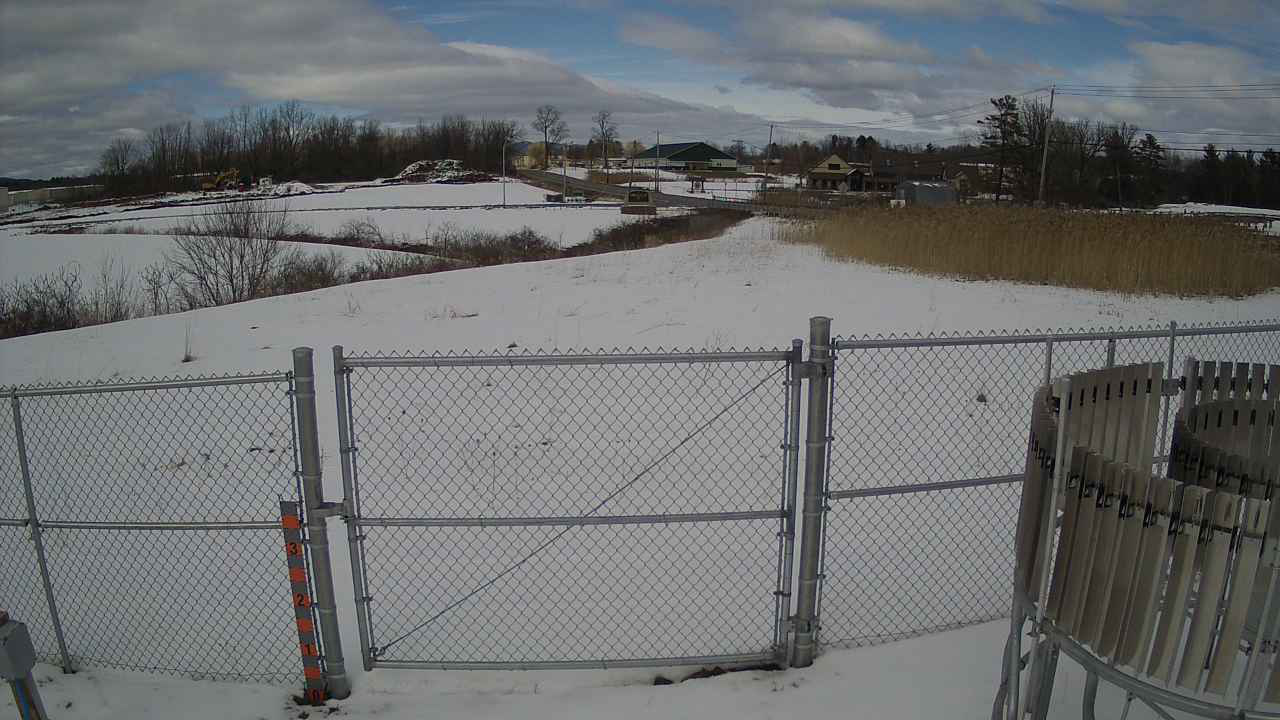

In [25]:
samples = ['/tf/NYSM/archive/nysm/cam_photos/2017/03/14/GFAL/20170314T150004_GFAL.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2019/05/05/BELD/20190505T135027_BELD.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2018/03/03/SCIP/20180303T125029_SCIP.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2019/05/15/GFAL/20190515T130527_GFAL.jpg',  #perfect vis with blue sky
           '/tf/NYSM/archive/nysm/cam_photos/2020/09/09/BATA/20200909T120026_BATA.jpg', #thick fog
           '/tf/NYSM/archive/nysm/cam_photos/2020/12/17/BATA/20201217T220027_BATA.jpg', #snow on the ground
           '/tf/NYSM/archive/nysm/cam_photos/2020/11/17/BATA/20201117T180026_BATA.jpg', #light fog
           '/tf/NYSM/archive/nysm/cam_photos/2020/09/24/BATA/20200924T180027_BATA.jpg', #perfect vis with hazy sky
           '/tf/NYSM/archive/nysm/cam_photos/2019/01/30/QUEE/20190130T204528_QUEE.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2019/01/30/QUEE/20190130T190527_QUEE.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2021/02/03/GROT/20210203T112533_GROT.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2018/07/16/PENN/20180716T083028_PENN.jpg']
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2018/03/11/GFAL/20180311T180026_GFAL.jpg' #'/tf/NYSM/archive/nysm/cam_photos/2021/02/05/BATA/20210205T050026_BATA.jpg'

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = predictions[0] #tf.nn.softmax(predictions[0]) #TODO get rid of softmax since activation already has it
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)

In [21]:
def predict1(path, model, class_names, img_height = 720, img_width = 1280):
    """
    Returns the predicted class and percent confidence for an image.
    
    :Parameters:
        path (str): path to image
        model (tf model)
        
    :rtype: tuple (str, float, 1d np array)
    """
    
    img = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = predictions[0]
    
    #print(predictions)
    return (class_names[np.argmax(score)], 100 * np.max(score), score)

    #TODO show all 4 probs

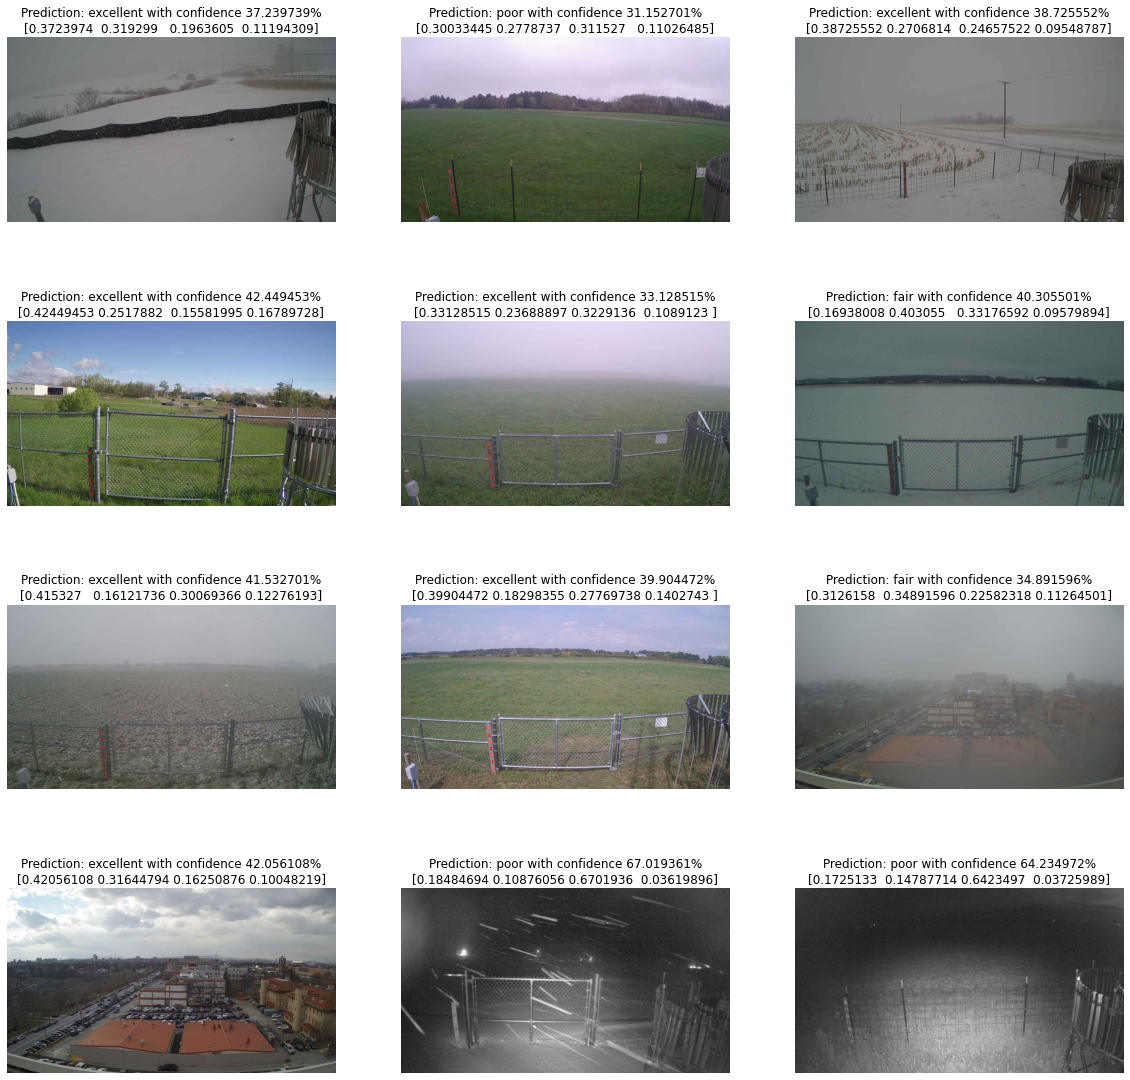

In [26]:
#display predictions for several images
plt.figure(figsize=(20, 20))
for i in range(len(samples)):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(plt.imread(samples[i]))
    plt.axis("off")
    plt.title("Prediction: %s with confidence %f%%\n%s" % predict1(samples[i], model, class_names))

# Fine tuning

Lock dense classification layers and unlock convolutional feature extraction layers.

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 1
addl_history = model.fit(train_gen,
                         epochs=fine_tune_epochs,
                         **train_kwargs)
total_epochs += fine_tune_epochs

In [ ]:
#uncomment to save augmented model
model.save("/tf/visibility/models/")

In [ ]:
#load model
# It can be used to reconstruct the model identically and i am going to load this model i ran overnight to save time.
# model = keras.models.load_model("/raid/arnold/clouds_detection/models/custom_cloud_classification_augmented_3_sites")

In [ ]:
tf_model_predictions = model.predict(images)

In [ ]:
print(tf_model_predictions.shape) #“Prediction results shape:”, (219, 7)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
# predicted_labels = class_names[predicted_ids]
print(predicted_ids)